# Rock Paper Scissors


In [1]:
# Print the current working directory
print('\n Current working directory: ' + os.getcwd() + '\n')


 Current working directory: c:\Users\bmars\Desktop\Uni-Bamberg\Semester5\ProjectXDeepLearning\shifumi\ModelEng



In [6]:
import os
import torch
#from google.colab import drive
# Mount the drive -- run this cell to connect your drive
#drive.mount('/content/drive')

# Set the shared folder as the working directory
os.chdir('/content/drive/My Drive/Uni/Project Deep Learning/Shifumi_ds')

# Print the current working directory
print('\n Current working directory: ' + os.getcwd() + '\n')

# Check if GPU is available
if torch.cuda.is_available():
    print('GPU is available!')
else:
    print('GPU is not available.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

 Current working directory: /content/drive/.shortcut-targets-by-id/0B04ys2xlOJRYfmstT2Q1Snc4cjI5U0M5THFjaVZhY3hTaVhPM1JJcUQxcWZQRi0xdDdfSjQ/Shifumi_ds

GPU is available!


In [7]:
import warnings
warnings.filterwarnings('ignore')

import os, sys, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import glob

# tweaks for libraries
np.set_printoptions(precision=6, linewidth=1024, suppress=True)
plt.style.use('seaborn')
sns.set_style('darkgrid')
sns.set_context('notebook',font_scale=1.10)

# Pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from tensorflow.keras.preprocessing.image import *
# My helper functions for training/evaluating etc.
#import pytorch_toolkit as pytk

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED);

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    #torch.backends.cudnn.enabled = False

In [8]:
CLASSES = ['rock', 'paper', 'scissors']

In [9]:
def get_data(image_paths):
    images, labels = [], []

    for image_path in image_paths:
        image = load_img(image_path, target_size=(32,32), color_mode='grayscale')
        image = img_to_array(image)
        label_name = image_path.split(os.path.sep) [-2]
        label = CLASSES.index(label_name)
        label = np.array(label).astype('int32')
        images.append(image)
        labels.append(label)

        #labels = np.expand_dims(labels, axis=0)

    return np.array(images), np.array(labels)

In [10]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Define the transformation
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip()    
])

# Create the dataset
dataset = ImageFolder(root='/content/drive/MyDrive/Uni/Project Deep Learning/Shifumi_ds/combined_pp_01_grey/combined', transform=transform)

# Create the train and validation datasets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create the test dataset
test_dataset = ImageFolder(root='/content/drive/MyDrive/Uni/Project Deep Learning/Shifumi_ds/xAI-Proj-M-validation_set', transform=transform)

# Create the DataLoaders
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# prints shape of images and labels using the first batch in the testloader - NON FUNCTIONAL
#images, labels = next(iter(trainloader))
#print(f"images.shape: {images.shape} - classes: {dataset.classes}")

In [11]:
import torch.nn as nn
import torch.optim as optim

def create_model(activate_dropout = True, dropout_probability = 0.4):
    net = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=5, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2,2),
    )
    if activate_dropout:
        net.add_module('dropout_1', nn.Dropout(dropout_probability))
        
    net.add_module('conv2', nn.Conv2d(32, 64, kernel_size=5, padding=1))
    net.add_module('relu2', nn.ReLU())
    net.add_module('batchnorm2', nn.BatchNorm2d(64))
    net.add_module('pool2', nn.MaxPool2d(2,2))

    if activate_dropout:
        net.add_module('dropout_2', nn.Dropout(dropout_probability))
        
    net.add_module('conv3', nn.Conv2d(64, 64, kernel_size=5, padding=1))
    net.add_module('relu3', nn.ReLU())
    net.add_module('batchnorm3', nn.BatchNorm2d(64))
    net.add_module('pool3', nn.MaxPool2d(2,2))

    if activate_dropout:
        net.add_module('dropout_3', nn.Dropout(dropout_probability))
    
    net.add_module('flatten', nn.Flatten())
    net.add_module('fc1', nn.Linear(64*2*2, 500))
    net.add_module('relu4', nn.ReLU())
    if activate_dropout:
        net.add_module('dropout_4', nn.Dropout(dropout_probability))

    net.add_module('fc2', nn.Linear(500, 3))

    return net


In [12]:
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self, activate_dropout=True, dropout_probability=0.5):
        super(MyModel, self).__init__()

        self.activate_dropout = activate_dropout
        self.dropout_probability = dropout_probability

        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2,2)
        self.dropout1 = nn.Dropout(self.dropout_probability)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2,2)
        self.dropout2 = nn.Dropout(self.dropout_probability)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=5, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2,2)
        self.dropout3 = nn.Dropout(self.dropout_probability)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*2*2, 500)

        self.dropout4 = nn.Dropout(self.dropout_probability)
        self.fc2 = nn.Linear(500, 3)

    def forward(self, x):
      x = self.conv1(x)
      x = nn.ReLU()(x)
      x = self.bn1(x)
      x = self.pool1(x)
      if self.activate_dropout:
          x = self.dropout1(x)

      x = self.conv2(x)
      x = nn.ReLU()(x)
      x = self.bn2(x)
      x = self.pool2(x)
      if self.activate_dropout:
          x = self.dropout2(x)

      x = self.conv3(x)
      x = nn.ReLU()(x)
      x = self.bn3(x)
      x = self.pool3(x)
      if self.activate_dropout:
          x = self.dropout3(x)

      x = self.flatten(x)

      x = self.fc1(x)
      x = nn.ReLU()(x)
      if self.activate_dropout:
          x = self.dropout4(x)

      x = self.fc2(x)
      return x

       


images.shape: (32, 1, 32, 32) - labels.shape: (32,)


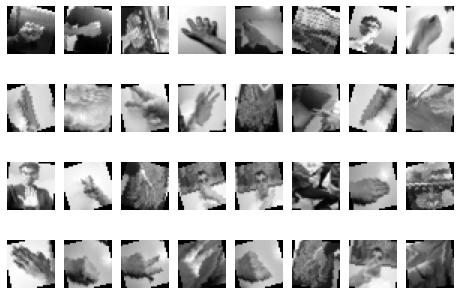

In [23]:
# Sample images - NON FUNCTIONAL
data_iter = iter(testloader)
sample_images, sample_labels = next(data_iter)
sample_images, sample_labels = sample_images.cpu().numpy(), sample_labels.cpu().numpy()
print(f"images.shape: {sample_images.shape} - labels.shape: {sample_labels.shape}")

for i in range(32):
    plt.subplot(4, 8, i + 1)
    image = sample_images[i]
    image = image.transpose((1,2,0))
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')
plt.show()


In [ ]:
net = create_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.001)

# Loop over the data iterator and update the model
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1} loss: {running_loss / len(trainloader)}')
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in valloader:
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Accuracy of the network on the validation set: {100 * correct / total}%')


def test_accuracy(testloader):
    # Test the model on the test dataset
    with torch.no_grad():
        correct = 0
        total = 0
        class_correct = [0. for i in range(3)]
        class_total = [0. for i in range(3)]
        for inputs, labels in testloader:
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            c = (predicted == labels).squeeze()
            for i in range(32):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
        print(f'Accuracy of the network on the test set: {100 * correct / total}%')
        for i in range(3):
            print(f'Accuracy of {dataset.classes[i]} : {100 * class_correct[i] / class_total[i]}%')
print('testing against the test dataset')
test_accuracy(testloader)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the model, loss function, and optimizer
model = MyModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validationloader = DataLoader(val_dataset, batch_size=64, shuffle=True)


# Loop over the data iterator and update the model
for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1} loss: {running_loss / len(trainloader)}')
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in validationloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Accuracy of the network on the validation set: {100 * correct / total}%')



def test_accuracy(testloader):
    # Test the model on the test dataset
    with torch.no_grad():
        correct = 0
        total = 0
        class_correct = [0. for i in range(3)]
        class_total = [0. for i in range(3)]
        for inputs, labels in testloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            c = (predicted == labels).squeeze()
            for i in range(32):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
        print(f'Accuracy of the network on the test set: {100 * correct / total}%')
        for i in range(3):
            print(f'Accuracy of {CLASSES[i]} : {100 * class_correct[i] / class_total[i]}%')

# Define the test dataloader
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
print('testing against the test dataset')
test_accuracy(testloader)


print('testing against the unknwon dataset')
file_pattern_unknown_images = f'/Users/amling/uni/shifumi/DataEng/datasets/xAI-Proj-M-validation_set_pp_01_grey/{x}/*.png'
dataset_paths_unknown_images = [*glob.glob(str(file_pattern_unknown_images))]
images_unknown, labels_unknown = get_data(dataset_paths_unknown_images)
unknown_ds = RPSDataset(images_unknown, labels_unknown, train_transforms)
test_accuracy(DataLoader(unknown_ds, batch_size=64, shuffle=False))

In [ ]:
MODEL_SAVE_PATH = './model_states/pytk_rock_paper_scissors_100epoches.pt'
#model.save(MODEL_SAVE_PATH)

## Evaluation

now there comes the evaluation part

In [ ]:
pytk.show_plots(hist, metric='acc', plot_title='Model Performance')

In [ ]:
loss, acc = model.evaluate_dataset(train_dataset)
print(f"Training  -> loss: {loss:.3f} - acc: {acc:.3f}")
loss, acc = model.evaluate_dataset(val_dataset)
print(f"Cross-val -> loss: {loss:.3f} - acc: {acc:.3f}")
loss, acc = model.evaluate_dataset(test_dataset)
print(f"Testing   -> loss: {loss:.3f} - acc: {acc:.3f}")

In [ ]:
for x in ['rock','paper','scissors','*']:
    file_pattern_unknown_images = f'/Users/amling/uni/shifumi/DataEng/datasets/xAI-Proj-M-validation_set_pp_01_grey/{x}/*.png'
    dataset_paths_unknown_images = [*glob.glob(str(file_pattern_unknown_images))]
    images_unknown, labels_unknown = get_data(dataset_paths_unknown_images)
    unknown_ds = RPSDataset(images_unknown, labels_unknown, train_transforms)
    loss, acc = model.evaluate_dataset(unknown_ds)
    print(f"Testing  {x} -> loss: {loss:.3f} - acc: {acc:.3f}")